<a href="https://colab.research.google.com/github/nicovakr/Pytorch-init/blob/master/DeepNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Training Deep Neural Network on GPU

In [1]:
import numpy as np
import matplotlib
import torch
import torchvision
import torchaudio

In [2]:
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
from torchvision.datasets import MNIST
from torchvision.transforms import ToTensor
from torchvision.utils import make_grid
from torch.utils.data.dataloader import DataLoader
from torch.utils.data import random_split
%matplotlib inline

#white background for figures
matplotlib.rcParams['figure.facecolor'] = '#ffffff'

In [3]:
# download & create PyTorch dataset using MNIST class from torchvision.datasets
dataset = MNIST(root='data/', download = True, transform=ToTensor())

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw



image.shape: torch.Size([1, 28, 28])
Label: 5


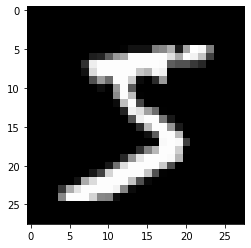

In [4]:
# image converted to Pytorch tensors w the shape 1x28x28 : color(x)width(x)height
# plt.imshow expects channels to be last dimension in an image tensor
# => use permute or np.squeeze to reorder dimensions of the image
image, label = dataset[0]
print('image.shape:', image.shape)
plt.imshow(np.squeeze(image), cmap='gray')
# np.squeeze(image) ou image.permute(1, 2, 0)
print('Label:', label)

In [5]:
# split dataset into training and validation dataset 
val_size = 10000
train_size = len(dataset) - val_size

train_ds, val_ds = random_split(dataset, [train_size, val_size])
len(train_ds), len(val_ds)

(50000, 10000)

In [6]:
batch_size = 128

In [7]:
# create Pytorch data loaders for training and validation

train_loader = DataLoader(train_ds, batch_size, shuffle=True, num_workers=4, pin_memory=True)
val_loader = DataLoader(val_ds, batch_size*2, num_workers=4, pin_memory=True)
# num_workers : number of subprocesses to use for data loading
#               if zero = data loaded in the main process
# pin_memory : True => the data loader will copy Tensors intpo CUDA pinned memory before returning them

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


images.shape: torch.Size([128, 1, 28, 28])


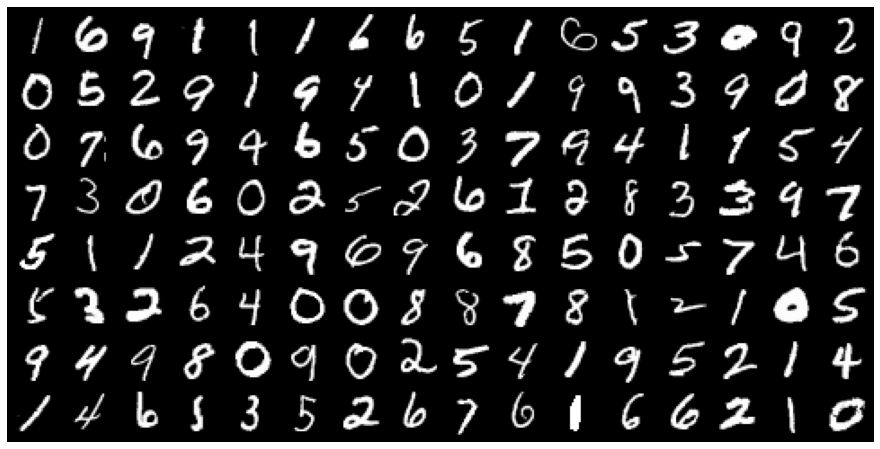

In [8]:
# visualizing a batch of data in a grid

for images, _ in train_loader:
  print('images.shape:', images.shape)
  plt.figure(figsize=(16,8))
  plt.axis('off')
  plt.imshow(make_grid(images, nrow=16).permute((1, 2, 0)))
  break

## Hidden layers, Activation functions and Non-linearity

Create a neural network with two layers : a hidden layer and an output layer.

We will add an activation function between the two layers.

In [9]:
# Create a batch of inputs tensors : 
# we must flatten the 1x28x28 images into vectors of size 784
#     to be passed into a nn.Linear object

for images, labels in train_loader:
  print('images.shape:', images.shape)
  inputs = images.reshape(-1, 784)
  print('inputs.shape:', inputs.shape)
  break

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


images.shape: torch.Size([128, 1, 28, 28])
inputs.shape: torch.Size([128, 784])


In [10]:
# Create a nn.Linear object which will serve as our hidden layer
# set the size of the output from the hidden layer to 32 
#       : can be increased or decreased to change the Learning Capacity of model

input_size = inputs.shape[-1]
hidden_size = 32 # learning capacity of the model

In [11]:
layer1 = nn.Linear(input_size, hidden_size)

In [12]:
inputs.shape

torch.Size([128, 784])

In [13]:
layer1_outputs = layer1(inputs)
print('layer1_outputs.shape:', layer1_outputs.shape)

layer1_outputs.shape: torch.Size([128, 32])


In [35]:
layer1.bias.shape

torch.Size([32])

In [37]:
# inputs{128x784}
# layer1weight{32x784}
# layer1bias{32}
# {128x784} @ tr({32x784}) + {32}
# = {128x32}
layer1_outputs_direct = inputs @ layer1.weight.t() + layer1.bias
layer1_outputs_direct.shape

torch.Size([128, 32])

In [15]:
# torch.allclose (input, other, relative_tolerance) -> BOOLEAN
# torch.allclose checks if inputs and other satisfy the condition :
# abs|input - compared| =< rel_tolerance * abs|other|
torch.allclose(layer1_outputs, layer1_outputs_direct, 1e-3)

True

In [ ]:
# layer1_outputs et inputs have a linear relationship : 
# => each element of layer1_outputs is a weighted sum of elements from inputs

In [16]:
# Activation function for the outputs : ReLU
# Rectified Linear Unit
# relu(x) = max(0,x)
# it simply replaces negative valuers in a given tensor with the value 0
# it is a non-linear function

F.relu(torch.tensor([[1, -1, 0],
                     [-0.1, .2, 3]]))

tensor([[1.0000, 0.0000, 0.0000],
        [0.0000, 0.2000, 3.0000]])

In [17]:
# apply the activation function to layer1_outputs and verifiy that negatives values
# were replaced with 0
relu_outputs = F.relu(layer1_outputs)
print('min(layer1_outputs):', torch.min(layer1_outputs).item())
print('min(relu_outputs):', torch.min(relu_outputs).item())

min(layer1_outputs): -0.8322372436523438
min(relu_outputs): 0.0


In [ ]:
# we have applied a non linear function
# relu_outputs and inputs do not have a linear relationship

# We refer to ReLU as the activation function beacause for each input
# certain outputs are activated (those with non-zero value) 
#       while others turned off (those with zero value)

In [18]:
# Create an output layer to convert vectors of length hidden_size in relu_outputs 
# into vectors of length 10 
# which is the desired output of our model (10 target labels)

output_size = 10
layer2 = nn.Linear(hidden_size, output_size)

In [19]:
layer2_outputs = layer2(relu_outputs)
print(layer2_outputs.shape)

torch.Size([128, 10])


In [20]:
inputs.shape

torch.Size([128, 784])

In [21]:
# we can use the layer2_outputs to compute the loss using F.cross_entropy
# and adjust the weights of layer1 and layer2 using SGD
F.cross_entropy(layer2_outputs, labels)

tensor(2.3074, grad_fn=<NllLossBackward0>)

In [24]:
# OUT = ( f(X x tr(W1) + b1) x tr(W2) + b2 )
# with : f the relu function
#        X the inputs {128,784}
#        W1 the layer1.weights {32,784}
#        b1 the layer1.bias {32}
#        W2 the layer2.weights {10,32}
#        b2 the layer2.bias {10}
outputs = (F.relu(inputs @ layer1.weight.t() + layer1.bias)) @ layer2.weight.t() + layer2.bias

In [25]:
torch.allclose(outputs, layer2_outputs, 1e-3)

True

Outputs and inputs do not have linear relationship due to the non-linear activation function. As we train the model and adjust the weights of layer1 and layer2, we can now capture non-linear relationship between the images and their labels.

In other words, introducing non-linearity makes the model more powerful and versatile. Also since hidden_size does not depend on the dimensions of the inputs or outputs, we vary it to increase the number of parameters within the model. We can also introduce new hidden layers and apply the same non-linear activation after each hidden layer.


In [54]:
# Test without the non-linearity 
outputs2 = (inputs @ layer1.weight.t() + layer1.bias) @ layer2.weight.t() + layer2.bias

In [56]:
# Create a single layer to replace the two linear layers
combined_layer = nn.Linear(input_size, output_size)
#                         ({128,784}  ,   {10})
combined_layer.weight.shape, combined_layer.bias.shape

(torch.Size([10, 784]), torch.Size([10]))

In [57]:
combined_layer.weight.data = layer2.weight @ layer1.weight
combined_layer.bias.data = layer1.bias @ layer2.weight.t() + layer2.bias

In [58]:
outputs3 = inputs @ combined_layer.weight.t() + combined_layer.bias

In [59]:
torch.allclose(outputs2, outputs3, 1e-3)

False